In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:

DIVIDEND = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv")
SCORE = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_ETF_SOR_IFO.csv")
ETF_Hoding = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_DATA_ETF_HOLDINGS.csv")
CUSTOMER = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_CUS_TP_IFO.csv")
INCOME_Outcome_Flow = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_IFW_OFW_IFO.csv")
DAY_Data = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_STK_DD_IFO.csv")
STOCK_Explane = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NW_FC_STK_IEM_IFO.csv")
OHLCV= pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_STK_DT_QUT.csv")


# 기본적인 EDA방법은 종단면과 횡단면으로 구분한다

-----

# CUSTOMER

기준일자, 티커종목코드, 고객구성대분류코드, 고객구성중분류코드, 고객구성계좌수비율, 고객구성투자비율

In [49]:
sorting_day = CUSTOMER['bse_dt'].value_counts().sort_index() 
#날짜 기준으로 묶을 필요가 있음
#sorting_day를 사용해서 하루하루 날짜 인덱싱 할 예정
sorting_day

bse_dt
20240528    18799
20240529    18796
20240530    18829
20240531    18845
20240603    18920
            ...  
20240820    19005
20240821    19024
20240822    19021
20240823    19058
20240826    19051
Name: count, Length: 63, dtype: int64

## 횡단면 분석
시간축을 고정하여 분석

In [50]:
cross_sample = CUSTOMER[CUSTOMER['bse_dt'] ==sorting_day.index[0]] #가장 첫날을 기준으로 확인
cross_sample_ticker =  cross_sample['tck_iem_cd'].value_counts()
cross_sample_llf = cross_sample['cus_cgr_llf_cd'].value_counts()
cross_sample_mlf = cross_sample['cus_cgr_mlf_cd'].value_counts()
cross_sample

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
206,20240528,AAL,2,22,37.9140,33.2190
207,20240528,AAL,2,23,23.5249,18.8676
210,20240528,AAL,2,24,12.5238,20.8803
211,20240528,AAL,2,25,4.5299,15.3642
212,20240528,AAL,2,21,21.5074,11.6688
...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522
1194593,20240528,ZS,3,33,33.3333,35.3987
1194594,20240528,ZS,3,31,37.2549,11.9073
1194886,20240528,ZS,1,12,98.0392,71.8211


In [51]:
AAL_Sample = cross_sample[cross_sample['tck_iem_cd'] == cross_sample_ticker.index[0]]
AAL_Sample

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
206,20240528,AAL,2,22,37.9140,33.2190
207,20240528,AAL,2,23,23.5249,18.8676
210,20240528,AAL,2,24,12.5238,20.8803
211,20240528,AAL,2,25,4.5299,15.3642
212,20240528,AAL,2,21,21.5074,11.6688
531,20240528,AAL,3,32,19.2615,29.5596
532,20240528,AAL,3,31,71.1077,27.8117
533,20240528,AAL,3,33,9.4024,40.4506
535,20240528,AAL,3,34,0.1903,2.1777
640,20240528,AAL,1,12,98.8199,97.4460


고객 구성 계좌 비율이 높으면 투자비율이 높을 확률이 크다. 계좌가 많다는 것은 투자를 많이 한다는 것임 그런데 계좌 비율이 높지 않은데 투자비율이 높은 분류가 존재할까? 
우리는 투자 계좌 비중이 작은데 투자 비중이 높은 그룹을 고래 그룹이라고 가정한다. 
1. 대분류 기준에서 봤을때 고래가 존재하는가? 
2. 중분류 기준에서 봤을때 고래가 존재하는가?
3. 종목간 차이가 있는가? 

In [55]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_llf'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

# 순위 차이가 양수이면 우리가 가정한 고래이다. (계좌 비율보다 투자비율이 높다)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/2389746522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/2389746522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2m

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt,act_cnt_rt_rank,ivs_rt_rank,rank_difference_llf
206,20240528,AAL,2,22,37.9140,33.2190,1619.0,2506.0,-887.0
207,20240528,AAL,2,23,23.5249,18.8676,4414.0,4319.0,95.0
210,20240528,AAL,2,24,12.5238,20.8803,6876.0,3992.0,2884.0
211,20240528,AAL,2,25,4.5299,15.3642,8510.0,4887.0,3623.0
212,20240528,AAL,2,21,21.5074,11.6688,4781.0,5546.0,-765.0
...,...,...,...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522,6070.5,2665.0,3405.5
1194593,20240528,ZS,3,33,33.3333,35.3987,2862.0,2618.0,244.0
1194594,20240528,ZS,3,31,37.2549,11.9073,2554.0,5050.0,-2496.0
1194886,20240528,ZS,1,12,98.0392,71.8211,1846.5,2335.0,-488.5


In [56]:
result = cross_sample.groupby('cus_cgr_llf_cd')['rank_difference_llf'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

cus_cgr_llf_cd                
1               positive_count     900
                negative_count     900
2               positive_count    4239
                negative_count    4324
3               positive_count    3195
                negative_count    3042
Name: rank_difference_llf, dtype: int64


1번 대 분류 그룹은 순위 차이가 존재하지 않음 2번과 3번은 존재하는데 유의미한 차이는 아닌것 같음 

**특히 1번은 모든 순위가 동일함**

In [57]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_mlf'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/1503364756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/1503364756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2m

In [59]:
result = cross_sample.groupby('cus_cgr_mlf_cd')['rank_difference_mlf'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

cus_cgr_mlf_cd                
11              positive_count     496
                negative_count     405
12              positive_count     405
                negative_count     496
21              positive_count     947
                negative_count     815
22              positive_count     981
                negative_count     957
23              positive_count    1040
                negative_count     849
24              positive_count     933
                negative_count     767
25              positive_count     685
                negative_count     589
31              positive_count     955
                negative_count     963
32              positive_count     873
                negative_count     939
33              positive_count     926
                negative_count     825
34              positive_count     421
                negative_count     327
Name: rank_difference_mlf, dtype: int64


중분류 간 차이는 거의 없는 거 같음

3. 종목간 차이가 있는가?

In [60]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_tick'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

# 순위 차이가 양수이면 우리가 가정한 고래이다. (계좌 비율보다 투자비율이 높다)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/3275228721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/3275228721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jkt

In [62]:
result = cross_sample.groupby('tck_iem_cd')['rank_difference_tick'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

tck_iem_cd                  
AA            positive_count    4
              negative_count    5
AAL           positive_count    4
              negative_count    3
AAN           positive_count    3
                               ..
ZVRA          negative_count    6
ZYME          positive_count    4
              negative_count    3
ZYXI          positive_count    1
              negative_count    2
Name: rank_difference_tick, Length: 4764, dtype: int64


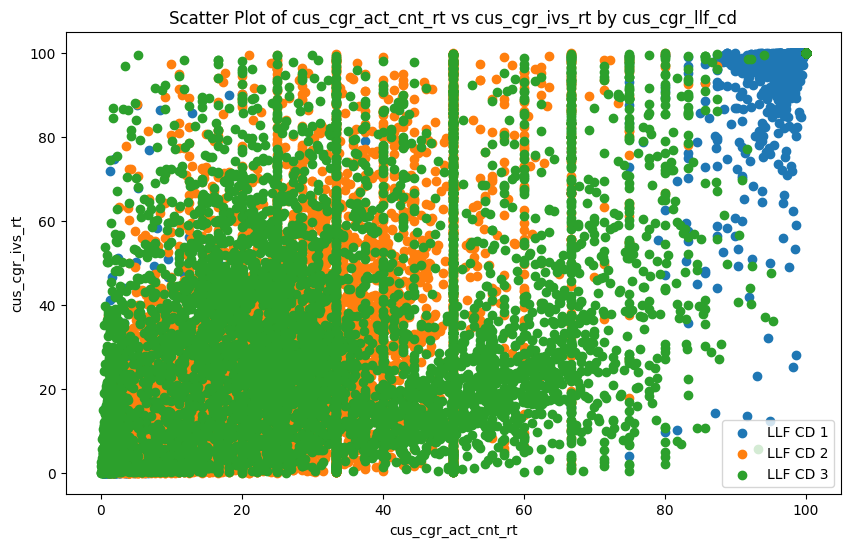

In [63]:
plt.figure(figsize=(10, 6))

# 다른 색으로 그룹별 구분
groups = cross_sample.groupby('cus_cgr_llf_cd')
for name, group in groups:
    plt.scatter(group['cus_cgr_act_cnt_rt'], group['cus_cgr_ivs_rt'], label=f'LLF CD {name}')

# 그래프 레이블 및 제목 설정
plt.xlabel('cus_cgr_act_cnt_rt')
plt.ylabel('cus_cgr_ivs_rt')
plt.title('Scatter Plot of cus_cgr_act_cnt_rt vs cus_cgr_ivs_rt by cus_cgr_llf_cd')
plt.legend()

# 그래프 출력
plt.show()

## 종단면 분석

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt,act_cnt_rt_rank,ivs_rt_rank,rank_difference
206,20240528,AAL,2,22,37.9140,33.2190,1619.0,2506.0,-887.0
207,20240528,AAL,2,23,23.5249,18.8676,4414.0,4319.0,95.0
210,20240528,AAL,2,24,12.5238,20.8803,6876.0,3992.0,2884.0
211,20240528,AAL,2,25,4.5299,15.3642,8510.0,4887.0,3623.0
212,20240528,AAL,2,21,21.5074,11.6688,4781.0,5546.0,-765.0
...,...,...,...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522,6070.5,2665.0,3405.5
1194593,20240528,ZS,3,33,33.3333,35.3987,2862.0,2618.0,244.0
1194594,20240528,ZS,3,31,37.2549,11.9073,2554.0,5050.0,-2496.0
1194886,20240528,ZS,1,12,98.0392,71.8211,1846.5,2335.0,-488.5


In [20]:
cross_sample['tck_iem_cd'] = 